In [1]:
# Khai báo thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

# Đọc dữ liệu từ file excel
df = pd.read_excel('Du_lieu_quan.xlsx')

print(df)

          Ngày  Nhiệt_độ Thời_tiết           Sự_kiện Khuyến_mại  Số_hóa_đơn  \
0   2024-01-01        16      Nắng             Không      Không          34   
1   2024-01-02        19      Nắng  Hội chợ việc làm      Không         212   
2   2024-01-03        18       Mưa             Không      Không          97   
3   2024-01-04        16      Nắng             Không      Không         102   
4   2024-01-05        16      Nắng             Không      Không          95   
..         ...       ...       ...               ...        ...         ...   
358 2024-12-26        15      Nắng             Không      Không         100   
359 2024-12-27        18      Nắng             Không      Không          89   
360 2024-12-28        18      Nắng             Không      Không          64   
361 2024-12-29        19      Nắng             Không         Có         102   
362 2024-12-30        20      Nắng             Không         Có         146   

    Sản_phẩm_bán_chạy  Tổng_doanh_thu_ngày  
0     

In [3]:
# Kiểm tra kích thước tập dữ liệu
print('Kích thước dữ liệu')
print(df.shape)

print('5 dòng đầu tiên')
print(df.head())

Kích thước dữ liệu
(363, 8)
5 dòng đầu tiên
        Ngày  Nhiệt_độ Thời_tiết           Sự_kiện Khuyến_mại  Số_hóa_đơn  \
0 2024-01-01        16      Nắng             Không      Không          34   
1 2024-01-02        19      Nắng  Hội chợ việc làm      Không         212   
2 2024-01-03        18       Mưa             Không      Không          97   
3 2024-01-04        16      Nắng             Không      Không         102   
4 2024-01-05        16      Nắng             Không      Không          95   

  Sản_phẩm_bán_chạy  Tổng_doanh_thu_ngày  
0           Trà sữa            1452000.0  
1         Trà chanh            8461000.0  
2            Cà phê            4028000.0  
3            Cà phê            3978000.0  
4           Trà sữa            3935000.0  


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Ngày                 363 non-null    datetime64[ns]
 1   Nhiệt_độ             363 non-null    int64         
 2   Thời_tiết            362 non-null    object        
 3   Sự_kiện              361 non-null    object        
 4   Khuyến_mại           362 non-null    object        
 5   Số_hóa_đơn           363 non-null    int64         
 6   Sản_phẩm_bán_chạy    363 non-null    object        
 7   Tổng_doanh_thu_ngày  354 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 22.8+ KB


In [7]:
# Kiểm tra giá trị thiếu 
df.isnull().sum()

Ngày                   0
Nhiệt_độ               0
Thời_tiết              1
Sự_kiện                2
Khuyến_mại             1
Số_hóa_đơn             0
Sản_phẩm_bán_chạy      0
Tổng_doanh_thu_ngày    9
dtype: int64

In [9]:
# Điền dữ liệu thiếu bằng giá trị trước đó
df['Thời_tiết'] = df['Thời_tiết'].ffill()
df['Sự_kiện'] = df['Sự_kiện'].ffill()
df['Khuyến_mại'] = df['Khuyến_mại'].ffill()

# Điền dữ liệu thiếu cột Tổng_doanh_thu_ngày
if df['Tổng_doanh_thu_ngày'].isnull().sum() > 0:
    median_doanh_thu = df['Tổng_doanh_thu_ngày'].median()
    df['Tổng_doanh_thu_ngày'] = df['Tổng_doanh_thu_ngày'].fillna(median_doanh_thu)

In [11]:
# Kiểm tra lại giá trị thiếu
df.isnull().sum()

Ngày                   0
Nhiệt_độ               0
Thời_tiết              0
Sự_kiện                0
Khuyến_mại             0
Số_hóa_đơn             0
Sản_phẩm_bán_chạy      0
Tổng_doanh_thu_ngày    0
dtype: int64

In [13]:
# sắp xếp dữ liệu theo ngày
df['Ngày'] = pd.to_datetime(df['Ngày'])
df = df.sort_values(by='Ngày').reset_index(drop=True)
# Tạo thêm 2 cột đặc trưng
df['lag1'] = df['Tổng_doanh_thu_ngày'].shift(1)
df['lag7'] = df['Tổng_doanh_thu_ngày'].shift(7)

# Xoá các dòng đầu có NaN
df = df.dropna().reset_index(drop=True)

cols = ['lag1', 'lag7']
df[cols] = df[cols].round(0)

In [15]:
# Hàm xác định loại ngày
def loai_ngay(row):
    # Ngày lễ: bạn liệt kê danh sách ngày lễ
    ngay_le = ['2024-01-01', '2024-02-10', '2024-04-30', '2024-05-01', '2024-09-02']
    if row.strftime('%Y-%m-%d') in ngay_le:
        return 'Ngày lễ'
    elif row.weekday() >= 5:  # Thứ 6=4, Thứ 7=5, Chủ nhật=6
        return 'Cuối tuần'
    else:
        return 'Ngày thường'

# Tạo cột loại ngày
df['Loại_ngày'] = df['Ngày'].apply(loai_ngay)

In [17]:
print(df)

          Ngày  Nhiệt_độ Thời_tiết          Sự_kiện Khuyến_mại  Số_hóa_đơn  \
0   2024-01-08        18       Mưa            Không      Không          96   
1   2024-01-09        16      Nắng            Không      Không          93   
2   2024-01-10        18       Mưa            Không      Không          98   
3   2024-01-11        18      Nắng            Không      Không          91   
4   2024-01-12        18       Mưa  Tổ chức ca nhạc         Có         193   
..         ...       ...       ...              ...        ...         ...   
351 2024-12-26        15      Nắng            Không      Không         100   
352 2024-12-27        18      Nắng            Không      Không          89   
353 2024-12-28        18      Nắng            Không      Không          64   
354 2024-12-29        19      Nắng            Không         Có         102   
355 2024-12-30        20      Nắng            Không         Có         146   

    Sản_phẩm_bán_chạy  Tổng_doanh_thu_ngày       lag1       lag

In [19]:
# Mã hóa sang số cột Sự_kiện và cột Khuyến_mại
df['Sự_kiện'] = df['Sự_kiện'].apply(lambda x: 0 if x == 'Không' else 1)
df['Khuyến_mại'] = df['Khuyến_mại'].apply(lambda x: 0 if x == 'Không' else 1)

In [21]:
column = ['Loại_ngày', 'Thời_tiết']

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[column])

# Tạo DataFrame từ dữ liệu đã mã hóa
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(column),
    index=df.index
)
# Ghép với các cột số
df_final = pd.concat(
    [df.drop(columns=column), encoded_df],
    axis=1
)

In [23]:
# Xóa bỏ các cột không cần thiết 
df_final = df_final.drop(columns=['Số_hóa_đơn','Sản_phẩm_bán_chạy','Loại_ngày_Cuối tuần'])

In [25]:
df_final.corr()['Tổng_doanh_thu_ngày'].sort_values(ascending=False)

Tổng_doanh_thu_ngày      1.000000
Sự_kiện                  0.608651
Loại_ngày_Ngày thường    0.543421
Khuyến_mại               0.355984
lag7                     0.209675
lag1                     0.177971
Nhiệt_độ                 0.177071
Thời_tiết_Mưa            0.040659
Ngày                     0.030600
Thời_tiết_Nắng          -0.040659
Loại_ngày_Ngày lễ       -0.201446
Name: Tổng_doanh_thu_ngày, dtype: float64

In [27]:
# Chuyển cột 'Ngày' sang kiểu datetime
df_final["Ngày"] = pd.to_datetime(df_final["Ngày"], format="%Y-%m-%d")

# Sắp xếp dữ liệu theo ngày
df_final = df_final.sort_values(by=["Ngày"]).reset_index(drop=True)
split_date = pd.to_datetime("2024-10-10")
train_df = df_final[df_final["Ngày"] < split_date]
test_df = df_final[df_final["Ngày"] >= split_date]

X_train = train_df.drop(['Tổng_doanh_thu_ngày','Ngày'], axis=1)
y_train = train_df["Tổng_doanh_thu_ngày"]
X_test = test_df.drop(['Tổng_doanh_thu_ngày','Ngày'], axis=1)
y_test = test_df["Tổng_doanh_thu_ngày"]


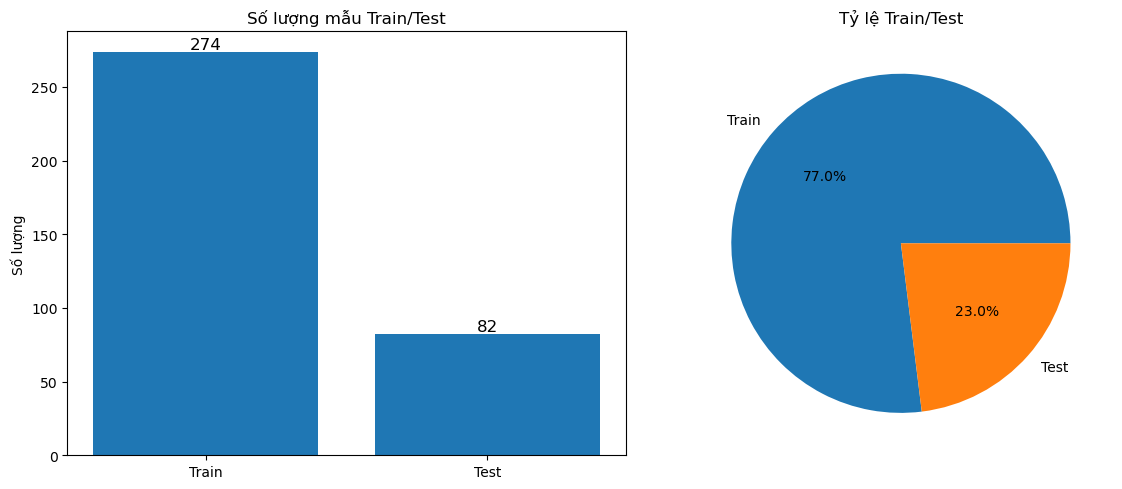

In [29]:
labels = ['Train', 'Test']
values = [len(X_train), len(X_test)]

plt.figure(figsize=(12,5))   

# Biểu đồ cột 
plt.subplot(1, 2, 1)
bars = plt.bar(labels, values)

# Hiển thị số lượng
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

plt.title('Số lượng mẫu Train/Test')
plt.ylabel('Số lượng')

# Biểu đồ tròn 
plt.subplot(1, 2, 2)
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Tỷ lệ Train/Test')

plt.tight_layout()
plt.show()


In [31]:
print(X_train)

     Nhiệt_độ  Sự_kiện  Khuyến_mại       lag1       lag7  Loại_ngày_Ngày lễ  \
0          18        0           0  2656000.0  1452000.0                0.0   
1          16        0           0  3789000.0  8461000.0                0.0   
2          18        0           0  3988000.0  4028000.0                0.0   
3          18        0           0  4150000.0  3978000.0                0.0   
4          18        1           1  3830000.0  3935000.0                0.0   
..        ...      ...         ...        ...        ...                ...   
269        20        0           0  4618000.0  3148000.0                0.0   
270        22        1           1  2983000.0  3048000.0                0.0   
271        21        0           0  7459000.0  4636000.0                0.0   
272        22        0           0  4662000.0  4626000.0                0.0   
273        24        0           0  4593000.0  4635000.0                0.0   

     Loại_ngày_Ngày thường  Thời_tiết_Mưa  Thời_tiế

In [33]:
print(X_test)

     Nhiệt_độ  Sự_kiện  Khuyến_mại       lag1       lag7  Loại_ngày_Ngày lễ  \
274        21        0           0  4634000.0  9134000.0                0.0   
275        24        0           0  4588000.0  4618000.0                0.0   
276        24        0           0  4663000.0  2983000.0                0.0   
277        21        0           0  2854000.0  7459000.0                0.0   
278        20        0           1  3131000.0  4662000.0                0.0   
..        ...      ...         ...        ...        ...                ...   
351        15        0           0  4058000.0  4050000.0                0.0   
352        18        0           0  4085000.0  3935000.0                0.0   
353        18        0           0  3803000.0  2793000.0                0.0   
354        19        0           1  2552000.0  2664000.0                0.0   
355        20        0           1  4116000.0  4135000.0                0.0   

     Loại_ngày_Ngày thường  Thời_tiết_Mưa  Thời_tiế

In [35]:
# Xây dựng mô hình
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [37]:
A = [[20,0,0,4116000,4135000,0,1,0,1]]
y_moi = model.predict(A)
print(y_moi)

[4617310.]


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


                 Feature  Importance
1                Sự_kiện    0.420637
6  Loại_ngày_Ngày thường    0.293648
2             Khuyến_mại    0.122745
0               Nhiệt_độ    0.109706
3                   lag1    0.021583
4                   lag7    0.020963
5      Loại_ngày_Ngày lễ    0.009246
8         Thời_tiết_Nắng    0.000789
7          Thời_tiết_Mưa    0.000683


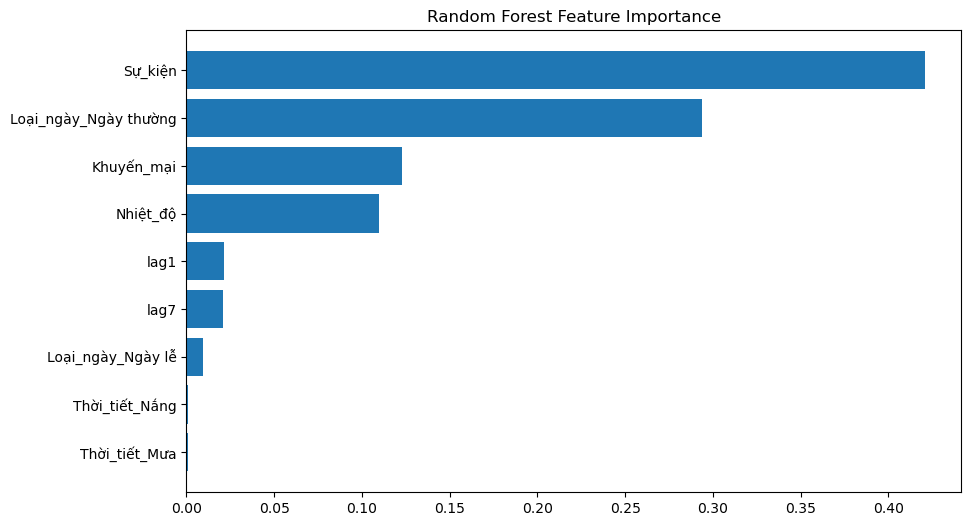

In [49]:
X = df_final.drop(columns=['Tổng_doanh_thu_ngày','Ngày'])   
y = df_final['Tổng_doanh_thu_ngày']                 

# Lấy feature importance
importances = model.feature_importances_

# Tạo bảng
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.show()


In [51]:
# Đánh giá chỉ sổ của mô hình
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100  

print(f"MAE: {mae:,.0f} VNĐ")
print(f"RMSE: {rmse:,.0f} VNĐ")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f} %")

MAE: 195,519 VNĐ
RMSE: 384,842 VNĐ
R²: 0.91
MAPE: 4.72 %


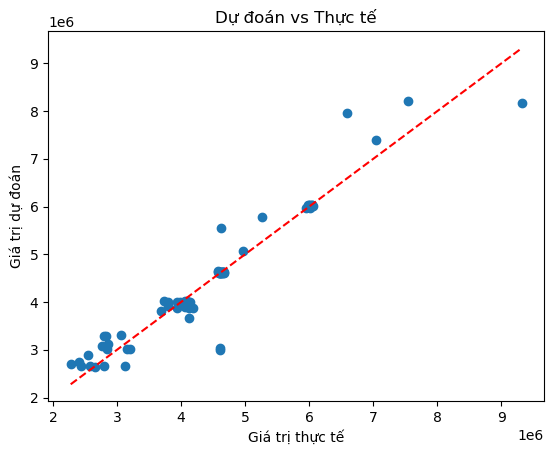

In [53]:
# Biểu đồ
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("Dự đoán vs Thực tế")
plt.show()

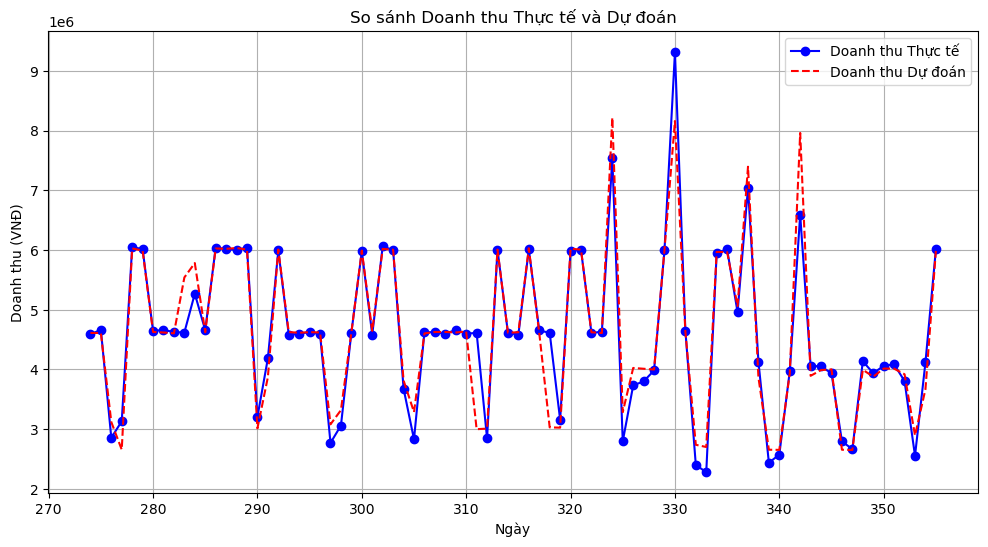

In [55]:
plt.figure(figsize=(12, 6))
dates = y_test.index 

plt.plot(dates, y_test, label='Doanh thu Thực tế', color='blue', marker='o')
plt.plot(dates, y_pred, label='Doanh thu Dự đoán', color='red', linestyle='--')

plt.title('So sánh Doanh thu Thực tế và Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu (VNĐ)')
plt.legend()
plt.grid(True)
plt.show()